In [35]:
# Making necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
import random
import time
from hmmlearn import hmm
import numpy as np
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import nltk
nltk.download('words')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from abc import ABC, abstractmethod

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [36]:
# reading the dataset
djia_dataset = pd.read_csv("DJA.csv")

In [37]:
djia_dataset = djia_dataset.dropna()

In [38]:
# reading the dataset
snp = pd.read_csv("SNP.csv")
snp = snp[1075:1829]
nasdaq = pd.read_csv("NASDAQCOM.csv")

Text(0, 0.5, 'Stock Close Price')

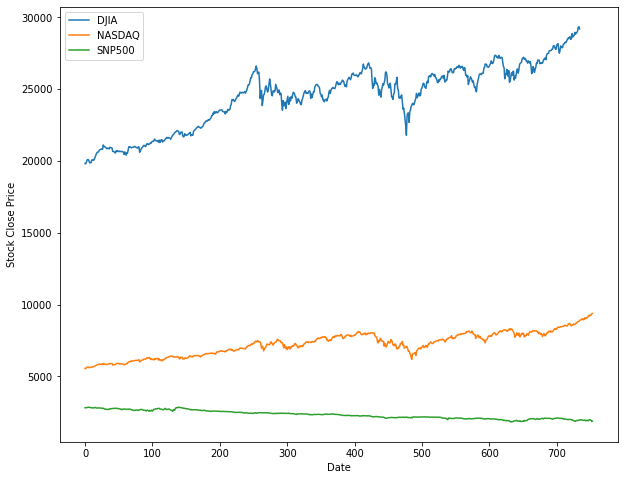

In [39]:
# Plot actual trend of data
fig = plt.figure(figsize=(10,8))
plt.plot(djia_dataset["DJIA"].tolist(), label='DJIA')
plt.plot(nasdaq["Close"].tolist(), label='NASDAQ')
plt.plot(snp["Close/Last"].tolist(), label='SNP500')
plt.legend(loc='upper left')
plt.xlabel("Date")
plt.ylabel("Stock Close Price")

In [40]:
# Function to calculate the variation
def find_variation(close_prices):
    variation = [0]
    for i in range(1, len(close_prices)):
        variation.append(((close_prices[i] - close_prices[i-1])/close_prices[i])*100)
    return variation

Text(0, 0.5, 'Variation')

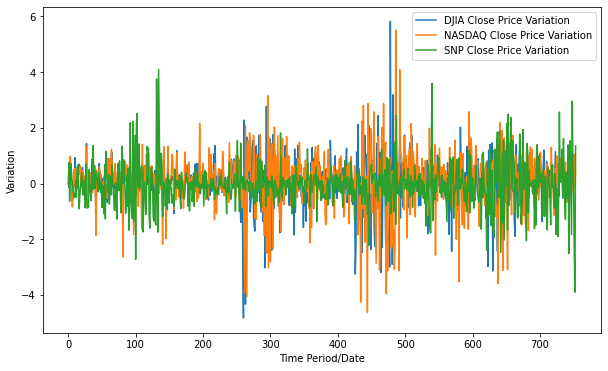

In [41]:
# Calculating and displaying variation
djia_variation = find_variation(djia_dataset["DJIA"].tolist())
snp_variation = find_variation(snp["Close/Last"].tolist())
nasdaq_variation = find_variation(nasdaq["Close"].tolist())
fig = plt.figure(figsize=(10,6))
plt.plot(djia_variation, label = 'DJIA Close Price Variation')
plt.plot(nasdaq_variation, label = 'NASDAQ Close Price Variation')
plt.plot(snp_variation, label='SNP Close Price Variation')
plt.legend(loc='upper right')
plt.xlabel('Time Period/Date')
plt.ylabel('Variation')

In [42]:
# Function to generate random transition matrix and starting probability
def generate_random_transition_matrix():
    k = 8
    result = [[random.uniform(0, 0.1 / k) for i in range(k)] for j in range(k)]
    for j, r in enumerate(result):
        r[j] += 1 - sum(r)
    return np.asarray(result)
def generate_random_start_prob():
    k = 8
    start_prob = [np.random.uniform(0,1) for _ in range(k)]
    start_prob = np.asarray(start_prob)
    start_prob = start_prob/np.sum(start_prob)
    return np.asarray(start_prob)

In [43]:
# CSP Solver
from queue import PriorityQueue
from abc import ABC, abstractmethod


class Constraint(ABC):
    def __init__(self, variables):
        self.variables = variables

    @abstractmethod
    def satisfied(self, assignment):
        pass


class CSP():
    def __init__(self, variables, domains):
        self.variables = variables
        self.domains = domains
        self.constraints = {}
        for variable in self.variables:
            self.constraints[variable] = []
            if variable not in self.domains:
                raise LookupError(
                    'Every variable should have a domain assigned to it.')

    def add_constraint(self, constraint):
        for variable in constraint.variables:
            if variable not in self.variables:
                raise LookupError("Variable in constraint not in CSP")
            else:
                self.constraints[variable].append(constraint)

    def consistent(self, variable, assignment):
        for constraint in self.constraints[variable]:
            if not constraint.satisfied(assignment):
                return False
        return True

    def backtracking_search(self, assignment={}):
        # assignment is complete if every variable is assigned (our base case)
        if len(assignment) == len(self.variables):
            return assignment
        # get all variables in the CSP but not in the assignment
        unassigned = [v for v in self.variables if v not in assignment]
        first = unassigned[0]
        for value in self.domains[first]:
            local_assignment = assignment.copy()
            local_assignment[first] = value
            # if we're still consistent, we recurse (continue)
            if self.consistent(first, local_assignment):
                result = self.backtracking_search(local_assignment)
                if result is not None:
                    return result
        return None


class Constraint(Constraint):
    def __init__(self, place1, place2):
        super().__init__([place1, place2])
        self.place1 = place1
        self.place2 = place2

    def satisfied(self, assignment):
        if self.place1 not in assignment or self.place2 not in assignment:
            return True
        return assignment[self.place1] != assignment[self.place2]

In [44]:
# Trump Tweet Sentiment Analysis
sid = SentimentIntensityAnalyzer()
words = set(nltk.corpus.words.words())
real_donald_trump = pd.read_csv("realdonaldtrump.csv")
trump_tweets = pd.read_csv("trumptweets.csv")
cond1 = real_donald_trump['date'] >= "2017-01-20"
cond2 = real_donald_trump['date'] <= "2020-01-20"
real_donald_trump = real_donald_trump.where((cond1 & cond2)).dropna()
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet)
         if w.lower() in words or not w.isalpha())
    return tweet
    

real_donald_trump['content_clean'] = real_donald_trump['content'].apply(cleaner)
word_dict = {'manipulate':-1,'manipulative':-1,'jamescharlesiscancelled':-1,'jamescharlesisoverparty':-1,
            'pedophile':-1,'pedo':-1,'cancel':-1,'cancelled':-1,'cancel culture':0.4,'teamtati':-1,'teamjames':1,
            'teamjamescharles':1,'liar':-1,'MAGA':-1}


sid = SentimentIntensityAnalyzer()
sid.lexicon.update(word_dict)

list1 = []
for i in real_donald_trump['content_clean']:
    list1.append((sid.polarity_scores(str(i)))['compound'])
real_donald_trump['sentiment'] = list1

In [45]:
# defining a dictionary of states
states_dict = {
    0: 'very-small-rise',
    1: 'small-rise',
    2: 'large-rise',
    3: 'very-large-rise',
    4: 'very-small-drop',
    5: 'small-drop',
    6: 'large-drop',
    7: 'very-large-drop',
}

In [46]:
# Function to train HMM without CSP
def training_hmm_without_csp(training_data):
    start_prob = generate_random_start_prob()
    transition_matrix = generate_random_transition_matrix()
    model = hmm.GMMHMM(n_components=8, n_mix = 7, covariance_type="diag", n_iter=10)
    model.fit(training_data)
    return model

In [47]:
# Function to train HMM with CSP
def training_hmm_with_csp(training_data, tweet_dataset):
    start_prob = generate_random_start_prob()
    transition_matrix = generate_random_transition_matrix()

    variables = [
    "0","1","2","3","4","5","6","7"
    ]
    domains = {
        "0":["0","1"],
        "1":["0","1"],
        "2":["0","1"],
        "3":["0","1"],
        "4":["0","1"],
        "5":["0","1"],
        "6":["0","1"],
        "7":["0","1"],
        "8":["0","1"],
    }
    csp = CSP(variables, domains)

    tweet_sentiment = tweet_dataset["sentiment"].tolist()
    # Adding constraints to our model
    for i in range(len(tweet_sentiment)):
        if(tweet_sentiment[i] >= 0.9): csp.add_constraint(Constraint("4","3"))
        if(tweet_sentiment[i] >= 0.6 and tweet_sentiment[i] < 0.9): csp.add_constraint(Constraint("1","2"))
        if(tweet_sentiment[i] >= 0.3 and tweet_sentiment[i] < 0.1): csp.add_constraint(Constraint("4","5"))
        else: csp.add_constraint(Constraint("6","7"))

    solution = csp.backtracking_search()
    transition_matrix = np.identity(8)
    model = hmm.GMMHMM(n_components=8, n_mix = 7, covariance_type="diag", n_iter=10)
    model.transmat_ = transition_matrix
    model.fit(training_data)

    return model
    

In [48]:
# Predict the index of states (hidden states)
def calculate_index_states(model, X_test):
    X_test = np.asarray(X_test).reshape(-1,1)
    index_states = model.predict(X_test)
    return index_states

In [49]:
# Classify the actual variation of each state (Index)
def classify_state_variation(variations):
    states = []
    for variation in variations:
        if(0 <= variation and variation < 0.1):
            states.append(0)
        elif(0.1 <= variation and variation < 1):
            states.append(1)
        elif(1 <= variation and variation < 2):
            states.append(2)
        elif(variation >= 2):
            states.append(3)
        elif(-0.1 < variation and variation <= 0):
            states.append(4)
        elif(-1 < variation and variation <= -0.1):
            states.append(5)
        elif(-2 < variation and variation <= -1):
            states.append(6)
        elif(variation <= -2):
            states.append(7)
    return states

In [50]:
snp_states = classify_state_variation(snp_variation)

In [51]:
# Choosing best out of 100 models with out CSP
def choose_best_model_without_csp(data):
    X = data
    X_train = X[:int(0.8*len(X))]
    X_test = X[int(0.8*len(X)):]
    X_train = np.asarray(X_train).reshape(-1, 1)
    X_test = np.asarray(X_test).reshape(-1, 1)
    model = training_hmm_without_csp(X_train)
    best_model = model.fit(X_train)
    best_model_score = best_model.score(X_test)
    print("Model 1: Score = " + str(best_model_score))
    for i in range(2,101):
        model = training_hmm_without_csp(X_train)
        print("Model " + str(i) + ": Score = " + str(model.score(X_test)))
        if(model.score(X_test) >= best_model_score):
            best_model_score = model.score(X_test)
            best_model = model

    print("Best Model Found - Score = " + str(best_model_score))
    return best_model, best_model_score

In [52]:
# Choosing best out of 100 models with CSP
def choose_best_model_with_csp(data, tweet_dataset):
    X = data
    X_train = X[:int(0.8*len(X))]
    X_test = X[int(0.8*len(X)):]
    X_train = np.asarray(X_train).reshape(-1, 1)
    X_test = np.asarray(X_test).reshape(-1, 1)
    model = training_hmm_without_csp(X_train)
    best_model = model.fit(X_train)
    best_model_score = best_model.score(X_test)
    print("Model 1: Score = " + str(best_model_score))
    for i in range(2,101):
        model = training_hmm_with_csp(X_train, tweet_dataset)
        print("Model " + str(i) + ": Score = " + str(model.score(X_test)))
        if(model.score(X_test) >= best_model_score):
            best_model_score = model.score(X_test)
            best_model = model

    print("Best Model Found - Score = " + str(best_model_score))
    return best_model, best_model_score

In [53]:
# Calculate best model params and score
snp_dataset_normalized = np.asarray(snp["Close/Last"].tolist())
snp_dataset_normalized = snp_dataset_normalized/sum(snp_dataset_normalized)
snp_dataset_normalized = snp_dataset_normalized.tolist()

best_model_without_csp, best_model_without_csp_score = choose_best_model_without_csp(snp_dataset_normalized)
best_model_with_csp, best_model_with_csp_score = choose_best_model_with_csp(snp_dataset_normalized, real_donald_trump)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


Model 1: Score = 982.7723439690309
Model 2: Score = 673.0670750991459
Model 3: Score = 865.1136841996206
Model 4: Score = 693.3648349688028
Model 5: Score = 965.4210973763011
Model 6: Score = 1017.8037946295952
Model 7: Score = 873.8850581619137
Model 8: Score = 969.877097451337
Model 9: Score = 994.5550906433862
Model 10: Score = 835.8525048520596
Model 11: Score = 928.663633154951
Model 12: Score = 966.309840422776
Model 13: Score = 877.3487950580077
Model 14: Score = 930.7332120304612
Model 15: Score = 980.3527114585464
Model 16: Score = 900.2010718064067
Model 17: Score = 964.9227555804645
Model 18: Score = 963.4933907516546
Model 19: Score = 962.3037502558376
Model 20: Score = 996.8285457731797
Model 21: Score = 843.9559737310124
Model 22: Score = 851.520446808184
Model 23: Score = 644.0908758511458
Model 24: Score = 856.3308857311138
Model 25: Score = 922.0323996149323
Model 26: Score = 984.3054392445842
Model 27: Score = 766.1824399821187
Model 28: Score = 926.4155669529285
Mode

c:\Users\rahul\AppData\Local\Programs\Python\Python39\lib\site-packages\hmmlearn\hmm.py:1238: RuntimeWarning: invalid value encountered in true_divide
  self.covars_ = c_n / c_d
Degenerate mixture covariance
Degenerate mixture covariance


Model 37: Score = nan
Model 38: Score = 822.2443159864207
Model 39: Score = 983.1553868535588
Model 40: Score = 995.2465409233539
Model 41: Score = 896.4098244869878
Model 42: Score = 989.2462974117773
Model 43: Score = 667.9947826253125
Model 44: Score = 921.574732236513
Model 45: Score = 919.967928065839


In [ ]:
# Calculate index of states
index_states_without_csp = calculate_index_states(best_model_without_csp, snp_dataset_normalized[int(0.8*len(snp_dataset_normalized)):])
index_states_with_csp = calculate_index_states(best_model_with_csp, snp_dataset_normalized[int(0.8*len(snp_dataset_normalized)):])

In [ ]:
snp_states_testing = snp_states[int(0.8*len(snp_dataset_normalized)):]

In [ ]:
# Count correct predictions
def correct_predictions(actual_states, calculated_states):
    count = 0
    for i in range(len(actual_states)):
        if(abs(actual_states[i] - calculated_states[i]) <= 3):
            count += 1
    return count

In [ ]:
# Calculate Accuracy
accuracy_without_csp = correct_predictions(snp_states_testing, index_states_without_csp)/len(snp_states_testing)
accuracy_with_csp = correct_predictions(snp_states_testing, index_states_with_csp)/len(snp_states_testing)

In [ ]:
accuracy_without_csp

0.5629139072847682

In [ ]:
# Calculate MAPE
def calculate_mape(actual_states, calculated_states):
    count = 0
    for i in range(len(actual_states)):
        count = count + abs((actual_states[i] - calculated_states[i])/(actual_states[i]+100))
    return (count/len(calculated_states))*100

In [ ]:
calculate_mape(snp_states_testing, index_states_without_csp)

2.4892682182385144

In [ ]:
# Predict Prices
def predict_prices(data, index_states):
    X = data
    price_variation = [-3,-2,-1,-0.1,0.1,1,2,3]
    predicted_prices = [X[int(0.8*len(X))-1]]
    for i in range(1, int(0.2*len(X))):
        new_price = predicted_prices[i-1] + predicted_prices[i-1]*price_variation[index_states[i]]/100
        predicted_prices.append(new_price)
    return predicted_prices    

In [ ]:
predict_prices_without_csp = predict_prices(snp_dataset_normalized, index_states_without_csp)
predict_prices_with_csp = predict_prices(snp_dataset_normalized, index_states_with_csp)

Text(0.5, 1.0, 'State transition without and with CSP - SNP 500')

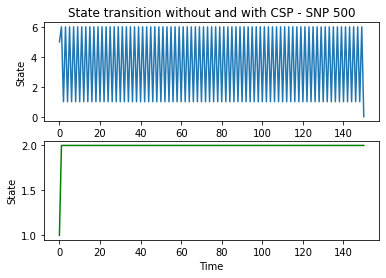

In [ ]:
# State Transition
#fig = plt.figure(figsize=(10,5))
fig, ax = plt.subplots(2)
ax[0].plot(index_states_without_csp, label = 'State transition without CSP')
ax[1].plot(index_states_with_csp,label = 'State transition with CSP', color='green')
ax[0].set_xlabel("Time")
ax[0].set_ylabel("State")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("State")
ax[0].set_title('State transition without and with CSP - SNP 500')

Text(0, 0.5, 'SNP500 Index Value')

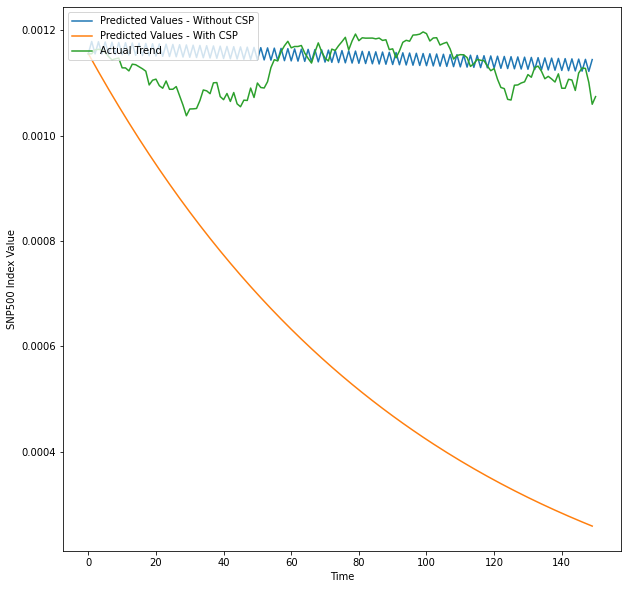

In [ ]:
# plot predicted trend vs actual trend
fig = plt.figure(figsize=(10,10))
plt.plot(predict_prices_without_csp, label = 'Predicted Values - Without CSP')
plt.plot(predict_prices_with_csp, label = 'Predicted Values - With CSP')
plt.plot(snp_dataset_normalized[int(0.8*len(snp_dataset_normalized)):], label = 'Actual Trend')
plt.legend(loc = 'upper left')
plt.xlabel("Time")
plt.ylabel("SNP500 Index Value")

In [ ]:
#import pickle
#with open("bestfitdjiamodeln.pkl", "wb") as f: 
#    pickle.dump(best_model, f)

In [ ]:
X = snp["Close/Last"].tolist()
X_train = X[:int(0.8*len(X))]
X_test = X[int(0.8*len(X)):]
X_train = np.asarray(X_train).reshape(-1, 1)
X_test = np.asarray(X_test).reshape(-1, 1)

In [ ]:
# Find time complexity
def finding_model_time(X_train, tweet_dataset):
    start_time = time.time()
    model = training_hmm_without_csp(X_train)
    print("--- %s seconds ---" % (time.time() - start_time))
    start_time = time.time()
    model = training_hmm_with_csp(X_train, tweet_dataset)
    print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
finding_model_time(X_train, real_donald_trump)

Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


--- 0.2905716896057129 seconds ---
--- 0.28335142135620117 seconds ---
